test
1e-06
1 1.0999999999999999 100.0 5.0 5.0
2 2.1000000000000005 100.0 9.0 1.0
3 3.1000000000000014 101.0 9.0 1.0
4 4.200000000000001 101.0 9.0 1.0
5 5.299999999999997 102.0 10.0 0.0
6 6.399999999999993 102.0 10.0 0.0
7 7.499999999999989 102.0 10.0 0.0
8 8.599999999999985 102.0 10.0 0.0
9 9.699999999999982 103.0 10.0 0.0
10 10.799999999999978 103.0 10.0 0.0
11 11.899999999999974 103.0 10.0 0.0
12 12.99999999999997 104.0 10.0 0.0
13 14.099999999999966 104.0 10.0 0.0
14 15.199999999999962 105.0 10.0 0.0
15 16.29999999999996 105.0 10.0 0.0
16 17.299999999999976 105.0 10.0 0.0
17 18.29999999999999 106.0 10.0 0.0
18 19.300000000000004 106.0 10.0 0.0
19 20.30000000000002 106.0 10.0 0.0
20 21.300000000000033 106.0 10.0 0.0
21 22.300000000000047 106.0 10.0 0.0
22 23.30000000000006 106.0 10.0 0.0
23 24.300000000000075 106.0 10.0 0.0
24 25.30000000000009 106.0 10.0 0.0
25 26.300000000000104 106.0 10.0 0.0
26 27.300000000000118 107.0 10.0 0.0
27 28.300000000000132 107.0 10.0 0.0
28 29.300000000

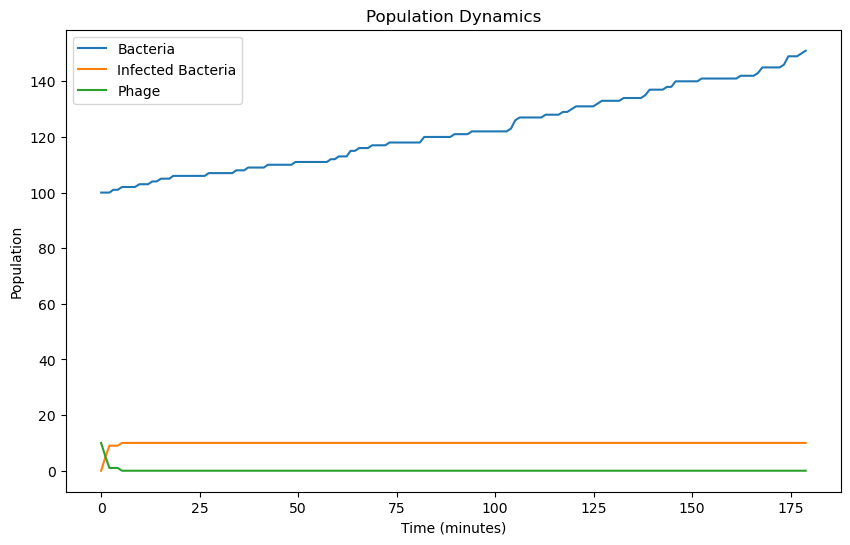

In [6]:
import numpy as np
import numba
import matplotlib.pyplot as plt

@numba.jit(nopython=True)
def simulate_polulation_agents(record_time_step, final_time,  bacteria, phage,infected,carrying_capacity, \
                               growth_rate, lysis_rate, burst_rate, eclipse, growth_timer, lysis_timer, eta, lysis_inhibition=False, lysis_inhibition_timer=5, \
                               lysis_from_without=False, lysis_from_without_phage=10, lo_resistance=False, lo_resistance_time=5, li_collapse=False, li_collapse_phage=100):
                    
    """
    Simulates a population dynamics with individulal bacteria has growth timer and lysis timer. 
    Simulate V ml. The number of phages (integer)

    Parameters:
    - time_step: The time step for evaluating the dynamics.
    -record_time_step: The time step for recording the dynamics.
    - final_time: The final time to simulate.
    - bacteria: The initial number of bacteria.
    - infected: The initial number of infected bacteria.
    - phage: The initial number of phage.
    - carrying_capacity: The carrying capacity of the environment. 
    system volume is calulcated from this assuming 1ml has carrying capacity of 10^9 cells. 
    - growth_rate: The growth rate of the bacteria.
    - lysis_rate: 1/The latency time of the phage production.
    - burst_rate The burst rate of the phage.
    - ecliplse: The ecliplse time of the phage.
    - growth_timer: Number of the growth timer of the bacteria.
    - lysis_timer: Number of the lysis timer of upon infection.
    - eta: The adsorption rate of the phage.
    - lysis_inhibition: Whether the lysis inhibition is present. Default is False.
    
    Returns:
    - time: A list of times.
    - Btimeseries: A list of the number of bacteria at each record time step.
    - Itimeseries: A list of the number of infected bacteria at each record time step.
    - Ptimeseries: A list of the number of phage at each record time step.
    """
    time_step = 0.1 #minutes
    volume=carrying_capacity/1e9 # volume in ml
    timenow = 0
    nrecord=int(final_time/record_time_step)
    time = np.zeros(nrecord)
    Btimeseries = np.zeros(nrecord)
    Itimeseries = np.zeros(nrecord)
    Ptimeseries = np.zeros(nrecord)
    irecord=0
    time[irecord]=timenow
    Btimeseries[irecord]=bacteria
    Itimeseries[irecord]=infected
    Ptimeseries[irecord]=phage
    grate= growth_rate*growth_timer
    lrate=lysis_rate*lysis_timer
    print(volume)
    Bstate = np.zeros(carrying_capacity) # 1 to growth_timer is uninfected, growth_timer+1 to growth_timer+lysis_timer is infected
    # assign a random integer number between 1 and growth_timer to each bacteria
    Pstate = np.zeros(carrying_capacity) # recording time spent in infected state, to compute number of produced phages for an infected bacteria, proportional to time spent in infected state (minus ecliplse)
    Istate = np.zeros(carrying_capacity) # Count the number of infection in total
    LORstate = np.zeros(carrying_capacity, np.bool_) # boolian, True if it is in Lysis from without resistant state
    Bstate[:bacteria] = np.random.randint(1, growth_timer+1, size=bacteria)
    bacteriaever=bacteria
    
    
    while timenow < final_time: 
        infectionrate=bacteria*eta*phage/volume
        if(infectionrate*time_step> phage/2):  
        #do staff with Gillespie
            Totalrate=infectionrate+(bacteria-infected)*grate+infected*lrate
            if(Totalrate==0):
                print("Extinction")
                break
            tau = np.random.exponential(1/Totalrate)
        
            if(timenow+tau>time[irecord]+record_time_step):
                irecord+=1
                time[irecord]=time[irecord-1]+record_time_step
                Btimeseries[irecord]=bacteria
                Itimeseries[irecord]=infected
                Ptimeseries[irecord]=phage
                print(irecord, time[irecord], Btimeseries[irecord], Itimeseries[irecord], Ptimeseries[irecord])

            timenow+=tau
            #recording the time spent in infected state
            mask = Bstate > growth_timer
            Pstate[mask] += tau
        
            event = np.random.rand()
            if event < infectionrate/Totalrate:
                phage-=1
                notinfect=True
                while notinfect:
                    j=np.random.randint(0,bacteriaever)
                    if(Bstate[j]>0):
                        Istate[j]+=1
                        if(lo_resistance):
                            if not LORstate[j] and Pstate[j] > lo_resistance_time:
                            # Code to execute when LORstate[j] is False and Pstate[j] > lo_resistance_time
                                LORstate[j]=True
                        if(Bstate[j]<=growth_timer):
                            infected+=1
                            Bstate[j]=growth_timer+1
                        else:
                            if not LORstate[j] and lysis_from_without :
                                if(Istate[j]>lysis_from_without_phage):    
                                    Bstate[j]=0
                                    infected-=1
                                    bacteria-=1
                                    phage+=max(int(burst_rate*(Pstate[j]-eclipse)),0)
                            if LORstate[j] or not lysis_from_without:
                                if lysis_inhibition:
                                    Bstate[j]=max(growth_timer+1, Bstate[j]-lysis_inhibition_timer)
                                if li_collapse and Istate[j]>li_collapse_phage:
                                    Bstate[j]=0
                                    infected-=1
                                    bacteria-=1
                                    phage+=max(int(burst_rate*(Pstate[j]-eclipse)),0)
                        notinfect=False
            elif event < (infectionrate+(bacteria-infected)*grate)/Totalrate:
                notgrown=True
                while notgrown:
                    j=np.random.randint(0,bacteriaever)
                    if(Bstate[j] > 0 and Bstate[j]<=growth_timer): 
                        if(Bstate[j]<growth_timer):
                            Bstate[j]+=1
                        else:
                            Bstate[j]=1
                            bacteria+=1
                            bacteriaever+=1
                            if(bacteriaever<carrying_capacity):
                                Bstate[bacteriaever-1]=1
                            else:
                                print("Carrying capacity reached")
                                timenow=final_time
                                break
                        notgrown=False
            else:
                notlysed=True
                while notlysed:
                    j=np.random.randint(0,bacteriaever)
                    if(Bstate[j]>growth_timer and Bstate[j]<=growth_timer+lysis_timer):
                        if(Bstate[j]<growth_timer+lysis_timer):
                            Bstate[j]+=1
                        else:
                            Bstate[j]=0
                            infected-=1
                            bacteria-=1
                            phage+=max(int(burst_rate*(Pstate[j]-eclipse)),0)
                        notlysed=False
        else:
            phagegone=0
            phagenew=0
            for i in range(bacteriaever):
                if(Bstate[i]>0):
                    phageinfect=np.random.poisson(eta*phage/volume*time_step)
                    if(phageinfect>0):
                        phagegone+=phageinfect
                        Istate[i]+=phageinfect
                        if Bstate[i]<=growth_timer:
                            infected+=1
                            Bstate[i]=growth_timer+1
                        if not LORstate[j] and lysis_from_without :
                            if(Istate[j]>lysis_from_without_phage):    
                                Bstate[j]=0
                                infected-=1
                                bacteria-=1
                                phagenew+=max(int(burst_rate*(Pstate[j]-eclipse)),0)
                        if LORstate[j] or not lysis_from_without:
                            if lysis_inhibition:
                                Bstate[j]=max(growth_timer+1, Bstate[j]-lysis_inhibition_timer*phageinfect)
                            if li_collapse and Istate[j]>li_collapse_phage:
                                Bstate[j]=0
                                infected-=1
                                bacteria-=1
                                phagenew+=max(int(burst_rate*(Pstate[j]-eclipse)),0) 
                    if Bstate[i]<growth_timer: 
                        if(np.random.rand()<growth_rate*time_step):
                            Bstate[i]+=1
                    elif Bstate[i]==growth_timer:
                        if(np.random.rand()<growth_rate*time_step):
                            Bstate[i]=1
                            bacteria+=1
                            bacteriaever+=1
                            if(bacteriaever<carrying_capacity):
                                Bstate[bacteriaever-1]=1
                            else:
                                print("Carrying capacity reached")
                                timenow=final_time
                                break
                    elif Bstate[i]<growth_timer+lysis_timer:
                        Pstate[j]+=time_step
                        if(lo_resistance):
                            if not LORstate[j] and Pstate[j] > lo_resistance_time:
                            # Code to execute when LORstate[j] is False and Pstate[j] > lo_resistance_time
                                LORstate[j]=True
                        if(np.random.rand()<lysis_rate*time_step):
                            Bstate[i]+=1
                    elif Bstate[i]==growth_timer+lysis_timer:
                        if(np.random.rand()<lysis_rate*time_step):
                            Bstate[i]=0
                            infected-=1
                            bacteria-=1
                            phagenew+=max(int(burst_rate*(Pstate[i]-eclipse)),0)
            
            phage=max(phage-phagegone+phagenew,0)
            timenow+=time_step
            if(timenow>time[irecord]+record_time_step):
                irecord+=1
                time[irecord]=timenow
                Btimeseries[irecord]=bacteria
                Itimeseries[irecord]=infected
                Ptimeseries[irecord]=phage
                print(irecord, time[irecord], Btimeseries[irecord], Itimeseries[irecord], Ptimeseries[irecord])
        
                          
    return time, Btimeseries, Itimeseries, Ptimeseries, irecord


record_time_step = 1 #minutes
final_time = 3*60 #minutes
carrying_capacity = int(1e3) #max cells
bacteria = int(1e2) #cells
phage = int(10) #pfu
infected=0
growth_rate = 2/60 #per minute
lysis_rate = 1/20  #per minute
growth_timer = 10 #max growth timer
lysis_timer = 50 #max lysis timer
eclipse = 5    #eclipse time in minutes
burst_size = 100 #burst size
burst_rate=burst_size/(1/lysis_rate-eclipse)
eta = 1e-8  #adsorption rate per ml/min
lysis_inhibition=True
lysis_inhibition_timer=5
lysis_from_without=True
lysis_from_without_phage=10
lo_resistance=True
lo_resistance_time=5
li_collapse=True
li_collapse_phage=80
print('test')
time, Btimeseries, Itimeseries, Ptimeseries, irecord = simulate_polulation_agents(record_time_step, final_time,  bacteria, phage, infected,carrying_capacity, \
                               growth_rate, lysis_rate, burst_rate,eclipse, growth_timer, lysis_timer, eta, lysis_inhibition, lysis_inhibition_timer, \
                                   lysis_from_without, lysis_from_without_phage, lo_resistance, lo_resistance_time, li_collapse, li_collapse_phage)



plt.figure(figsize=(10, 6))
plt.plot(time[:irecord], Btimeseries[:irecord], label='Bacteria')
plt.plot(time[:irecord], Itimeseries[:irecord], label='Infected Bacteria')
plt.plot(time[:irecord], Ptimeseries[:irecord], label='Phage')
plt.xlabel('Time (minutes)')
plt.ylabel('Population')
plt.title('Population Dynamics')
plt.legend()
plt.show()

In [5]:
print(irecord, int(final_time/record_time_step))

18 18
